**Question 3**

Training a convnet from scratch on a small dataset


The relevance of deep learning for small-data problems

Downloading the data

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lauralu521","key":"dd65f9e99c75adc5f211aee4315313c6"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c dogs-vs-cats

100% 811M/812M [00:37<00:00, 25.3MB/s]
100% 812M/812M [00:37<00:00, 22.5MB/s]


In [4]:
!unzip -qq dogs-vs-cats.zip

In [5]:
!unzip -qq train.zip

Copying images to training, validation, and test directories.

In [6]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=2000)
make_subset("validation", start_index=2000, end_index=2500)
make_subset("test", start_index=2500, end_index=3000)

Building the model

Instantiating a small convnet for dogs vs. cats classification

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

Configuring the model for training

In [9]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Data preprocessing

Using image_dataset_from_directory to read images

In [10]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 4000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [11]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(2000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [12]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [13]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [14]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


Displaying the shapes of the data and labels yielded by the Dataset

In [15]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


Fitting the model using a Dataset

In [16]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
125/125 [==============================] - 19s 62ms/step - loss: 0.6981 - accuracy: 0.5117 - val_loss: 0.6870 - val_accuracy: 0.5880
Epoch 2/30
125/125 [==============================] - 7s 51ms/step - loss: 0.6834 - accuracy: 0.5782 - val_loss: 0.6390 - val_accuracy: 0.6440
Epoch 3/30
125/125 [==============================] - 7s 51ms/step - loss: 0.6298 - accuracy: 0.6467 - val_loss: 0.5926 - val_accuracy: 0.6680
Epoch 4/30
125/125 [==============================] - 7s 51ms/step - loss: 0.5841 - accuracy: 0.6938 - val_loss: 0.5689 - val_accuracy: 0.7100
Epoch 5/30
125/125 [==============================] - 8s 60ms/step - loss: 0.5486 - accuracy: 0.7117 - val_loss: 0.5668 - val_accuracy: 0.7130
Epoch 6/30
125/125 [==============================] - 7s 57ms/step - loss: 0.5163 - accuracy: 0.7485 - val_loss: 0.5584 - val_accuracy: 0.7330
Epoch 7/30
125/125 [==============================] - 7s 51ms/step - loss: 0.4770 - accuracy: 0.7728 - val_loss: 0.5686 - val_accuracy: 0.712

Displaying curves of loss and accuracy during training

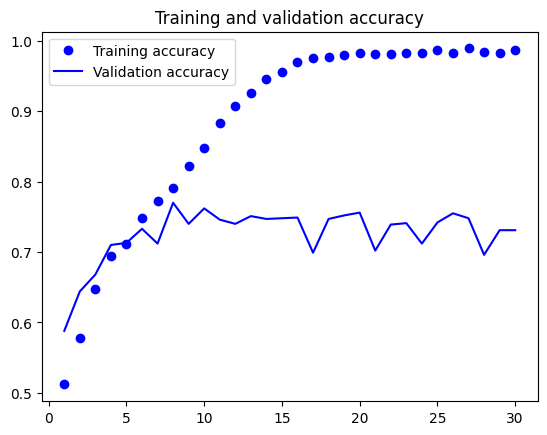

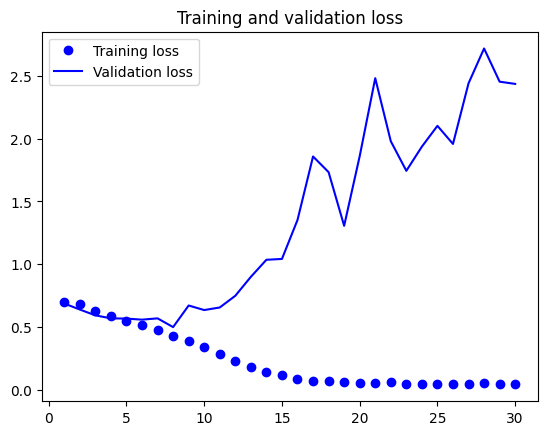

In [17]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Evaluating the model on the test set

In [18]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 30ms/step - loss: 0.5406 - accuracy: 0.7310
Test accuracy: 0.731


Using data augmentation

Define a data augmentation stage to add to an image model

In [19]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

Displaying some randomly augmented training images

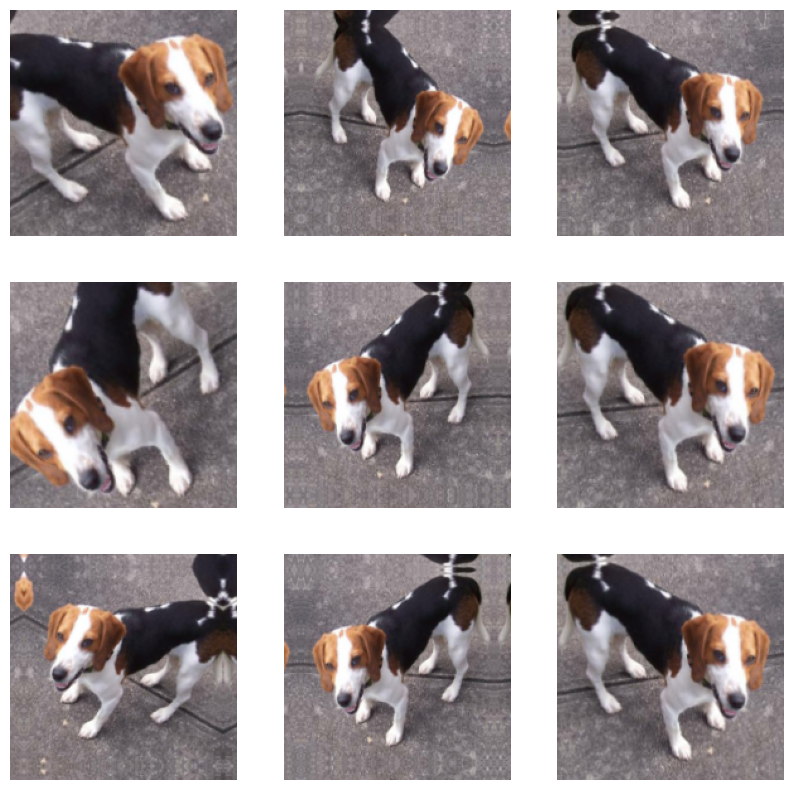

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Defining a new convnet that includes image augmentation and dropout

In [21]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Training the regularized convnet

In [22]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
125/125 [==============================] - 10s 61ms/step - loss: 0.7103 - accuracy: 0.5065 - val_loss: 0.6921 - val_accuracy: 0.5000
Epoch 2/100
125/125 [==============================] - 7s 54ms/step - loss: 0.6937 - accuracy: 0.5242 - val_loss: 0.6824 - val_accuracy: 0.6160
Epoch 3/100
125/125 [==============================] - 7s 53ms/step - loss: 0.6778 - accuracy: 0.5800 - val_loss: 0.6699 - val_accuracy: 0.5910
Epoch 4/100
125/125 [==============================] - 7s 56ms/step - loss: 0.6562 - accuracy: 0.6263 - val_loss: 0.6342 - val_accuracy: 0.6440
Epoch 5/100
125/125 [==============================] - 8s 61ms/step - loss: 0.6306 - accuracy: 0.6518 - val_loss: 0.5874 - val_accuracy: 0.6930
Epoch 6/100
125/125 [==============================] - 8s 66ms/step - loss: 0.6041 - accuracy: 0.6768 - val_loss: 0.5612 - val_accuracy: 0.7220
Epoch 7/100
125/125 [==============================] - 8s 59ms/step - loss: 0.5826 - accuracy: 0.6985 - val_loss: 0.5456 - val_accuracy

Evaluating the model on the test set

In [23]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 28ms/step - loss: 0.3068 - accuracy: 0.8790
Test accuracy: 0.879
